<a href="https://colab.research.google.com/github/fernandopr11/ModelFaceInceptionV1FineTuning/blob/main/FacialRecognitionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Instalacion de dependencias
!pip install torch torchvision facenet-pytorch opencv-python pillow numpy pandas matplotlib seaborn scikit-learn tqdm albumentations mtcnn coremltools onnx onnx-coreml tqdm albumentations

In [2]:
# PASO 1. Carga del modelo preentrenado

#Importacion de librerias iniciales para la configuracion de directorios y carga del modelo preentrenado
import torch
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

In [3]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dispositivo: cpu


In [4]:
# Crear directorios en Google Drive
base_path = Path("/content/drive/MyDrive/Reconocimiento_Facial")
models_dir = base_path / "models"
data_dir = base_path / "data"
results_dir = base_path / "results"

# Crear estructura de directorios
base_path.mkdir(exist_ok=True)
models_dir.mkdir(exist_ok=True)
data_dir.mkdir(exist_ok=True)
results_dir.mkdir(exist_ok=True)


In [5]:
# Subdirectorios para organizar mejor los datos
(data_dir / "raw").mkdir(exist_ok=True)
(data_dir / "processed").mkdir(exist_ok=True)
(data_dir / "train_test").mkdir(exist_ok=True)

In [6]:
# Veriricar la creacion de los directorios
print(f"Directorios creados en: {base_path}")
print(f"📁 models: {models_dir}")
print(f"📁 data: {data_dir}")
print(f"📁 results: {results_dir}")

Directorios creados en: /content/drive/MyDrive/Reconocimiento_Facial
📁 models: /content/drive/MyDrive/Reconocimiento_Facial/models
📁 data: /content/drive/MyDrive/Reconocimiento_Facial/data
📁 results: /content/drive/MyDrive/Reconocimiento_Facial/results


In [7]:
print("Cargando InceptionResnetV1...")
model = InceptionResnetV1(
    pretrained='vggface2',  # Pesos preentrenados en VGGFace2
    classify=False,         # Solo extracción de características
    device=device
).eval()

Cargando InceptionResnetV1...


In [8]:
print(f"Modelo cargado exitosamente")
print(f"Parámetros: {sum(p.numel() for p in model.parameters()):,}")

Modelo cargado exitosamente
Parámetros: 27,910,327


In [9]:
# Prueba de funcionamiento
test_input = torch.randn(1, 3, 160, 160).to(device)
with torch.no_grad():
    embedding = model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Embedding shape: {embedding.shape}")
print(f"Embedding size: {embedding.shape[1]} (512 esperado)")

Input shape: torch.Size([1, 3, 160, 160])
Embedding shape: torch.Size([1, 512])
Embedding size: 512 (512 esperado)


In [10]:
# Guardar el modelo en Google Drive
model_path = models_dir / "inception_resnet_v1_base.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'pretrained': 'vggface2',
        'embedding_size': 512,
        'img_size': 160
    }
}, model_path)

print(f"Modelo guardado en: {model_path}")

Modelo guardado en: /content/drive/MyDrive/Reconocimiento_Facial/models/inception_resnet_v1_base.pth


In [11]:

#PASO 2: Preprocesamiento del dataset y augmentación de datos
import cv2
from PIL import Image, ImageEnhance
from facenet_pytorch import MTCNN
from tqdm import tqdm
import albumentations as A
import random


In [12]:
# PASO 2.1: Configurar detector de rostros MTCNN
print("🔍 Configurando detector de rostros MTCNN...")
mtcnn = MTCNN(
    image_size=160,              # Tamaño de salida del rostro (compatible con InceptionResnetV1)
    margin=20,                   # Margen alrededor del rostro
    min_face_size=80,            # Tamaño mínimo de rostro a detectar
    thresholds=[0.6, 0.7, 0.7],  # Umbrales de detección [P, R, O]
    factor=0.709,                # Factor de escala para pirámide de imágenes
    post_process=True,           # Normalización automática
    device=device
)
print("✅ Detector MTCNN configurado")

🔍 Configurando detector de rostros MTCNN...
✅ Detector MTCNN configurado


In [13]:
# PASO 2.2: Función para detectar y extraer rostros
def detectar_y_extraer_rostro(imagen_path, mostrar=False):
    """
    Detecta y extrae el rostro principal de una imagen usando MTCNN
    """
    try:
        # Cargar imagen
        img = Image.open(imagen_path).convert('RGB')

        # Detectar rostro con MTCNN
        img_cropped = mtcnn(img)

        if img_cropped is not None:
            # Convertir tensor a PIL Image
            if isinstance(img_cropped, torch.Tensor):
                # Desnormalizar de [-1,1] a [0,255]
                img_cropped = (img_cropped + 1) / 2 * 255
                img_cropped = img_cropped.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                img_cropped = Image.fromarray(img_cropped)

            if mostrar:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title("Original")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(img_cropped)
                plt.title(f"Rostro Detectado ({img_cropped.size})")
                plt.axis('off')
                plt.show()

            return img_cropped
        else:
            print(f"⚠️  No se detectó rostro en {imagen_path.name}")
            return None

    except Exception as e:
        print(f"❌ Error procesando {imagen_path.name}: {str(e)}")
        return None


👤 EXTRAYENDO ROSTROS DE IMÁGENES ORIGINALES...
📂 Buscando en: /content/drive/MyDrive/Reconocimiento_Facial/data/raw/
📸 Encontradas 15 fotos originales

🖼️  Ejemplo de detección con: Copia de Copia de B51AD7BC-10A4-4CFD-AACB-55AE1850B930.JPG


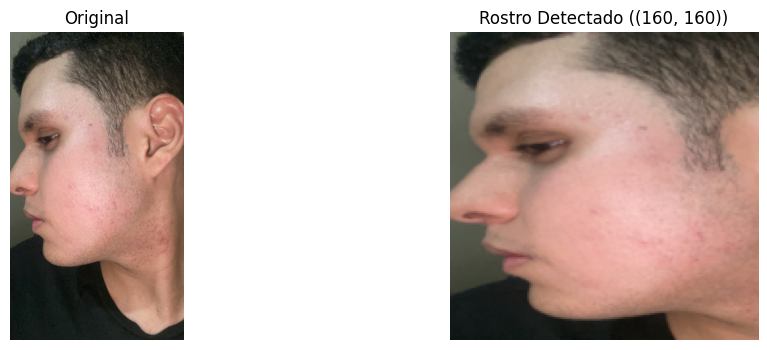


🔄 Procesando 15 imágenes...


Detectando rostros: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]

✅ Rostros extraídos: 15/15


In [43]:
# PASO 2.3: Extraer rostros de todas las imágenes originales
print("\n👤 EXTRAYENDO ROSTROS DE IMÁGENES ORIGINALES...")

# Buscar todas las fotos en data/raw
fotos_originales = list(data_dir.glob("raw/*.jpg")) + list(data_dir.glob("raw/*.JPG")) + \
                  list(data_dir.glob("raw/*.png")) + list(data_dir.glob("raw/*.PNG"))

print(f"📂 Buscando en: {data_dir}/raw/")
print(f"📸 Encontradas {len(fotos_originales)} fotos originales")

if len(fotos_originales) == 0:
    print("❌ No se encontraron fotos en /data/raw/")
    print("Verifica que las fotos estén en la carpeta correcta")
else:
    rostros_detectados = []
    nombres_rostros = []

    # Mostrar primera imagen como ejemplo
    if len(fotos_originales) > 0:
        print(f"\n🖼️  Ejemplo de detección con: {fotos_originales[0].name}")
        rostro_ejemplo = detectar_y_extraer_rostro(fotos_originales[0], mostrar=True)

    # Procesar todas las imágenes
    print(f"\n🔄 Procesando {len(fotos_originales)} imágenes...")
    for i, foto_path in enumerate(tqdm(fotos_originales, desc="Detectando rostros")):
        rostro = detectar_y_extraer_rostro(foto_path)
        if rostro is not None:
            # Guardar rostro procesado
            nombre_rostro = f"face_{i+1:03d}.jpg"
            ruta_rostro = data_dir / "processed" / nombre_rostro
            rostro.save(ruta_rostro, quality=95)

            rostros_detectados.append(nombre_rostro)

    print(f"✅ Rostros extraídos: {len(rostros_detectados)}/{len(fotos_originales)}")

In [15]:
# PASO 2.4: Configurar augmentación de datos
print("\n🔧 CONFIGURANDO AUGMENTACIÓN DE DATOS...")

# Configurar transformaciones con Albumentations (versión SIMPLE Y QUE FUNCIONA)
transform_augment = A.Compose([
    # Transformaciones básicas
    A.HorizontalFlip(p=0.4),                                                   # Espejo horizontal
    A.Rotate(limit=8, p=0.6),                                                  # Rotación suave ±8°

    # Variaciones de ILUMINACIÓN (probadas y que funcionan)
    A.OneOf([
        # Iluminación normal
        A.RandomBrightnessContrast(
            brightness_limit=0.15, contrast_limit=0.1, p=1.0
        ),
        # Poca iluminación (ambiente oscuro)
        A.RandomBrightnessContrast(
            brightness_limit=(-0.25, 0.0), contrast_limit=0.15, p=1.0
        ),
        # Iluminación alta (muy iluminado)
        A.RandomBrightnessContrast(
            brightness_limit=(0.05, 0.2), contrast_limit=0.1, p=1.0
        ),
    ], p=0.7),

    # Ajustes de color SUTILES (sin problemas)
    A.HueSaturationValue(
        hue_shift_limit=8, sat_shift_limit=12, val_shift_limit=10, p=0.4
    ),

    # Transformaciones geométricas suaves
    A.Affine(
        translate_percent=0.02,     # Desplazamiento mínimo 2%
        scale=(0.98, 1.02),        # Escala muy sutil 98%-102%
        rotate=5,                  # Rotación máxima 5°
        p=0.4
    ),

    # Efectos de cámara simples
    A.OneOf([
        # Ligero desenfoque
        A.GaussianBlur(blur_limit=2, p=1.0),
        # Sin efecto
        A.NoOp(p=1.0),
    ], p=0.2),  # Solo 20% probabilidad

    # Ajuste gamma para diferentes exposiciones
    A.RandomGamma(gamma_limit=(85, 115), p=0.3),

], p=0.85)  # 85% probabilidad de aplicar alguna transformación

def aplicar_augmentacion(imagen_pil, num_variaciones=25):
    """
    Aplica múltiples augmentaciones a una imagen PIL
    """
    variaciones = []

    # Convertir PIL a numpy para Albumentations
    img_np = np.array(imagen_pil)

    for i in range(num_variaciones):
        # Aplicar augmentación
        augmented = transform_augment(image=img_np)
        img_aug = augmented['image']

        # Convertir de vuelta a PIL
        img_pil_aug = Image.fromarray(img_aug)
        variaciones.append(img_pil_aug)

    return variaciones


🔧 CONFIGURANDO AUGMENTACIÓN DE DATOS...


In [16]:

# PASO 2.5: Generar variaciones aumentadas
if len(rostros_detectados) > 0:
    print(f"\n📈 GENERANDO VARIACIONES AUMENTADAS...")

    # Configurar cuántas variaciones por rostro
    VARIACIONES_POR_ROSTRO = 20  # Ajusta este número según necesites
    total_variaciones = len(rostros_detectados) * VARIACIONES_POR_ROSTRO

    print(f"🎯 Generando {VARIACIONES_POR_ROSTRO} variaciones por cada {len(rostros_detectados)} rostros")
    print(f"📊 Total de imágenes finales: {total_variaciones}")

    contador_total = 0

    # Crear carpeta para augmentadas
    augmented_dir = data_dir / "processed" / "augmented"
    augmented_dir.mkdir(exist_ok=True)

    # Procesar cada rostro detectado
    for nombre_rostro in tqdm(rostros_detectados, desc="Generando variaciones"):
        # Cargar rostro original
        ruta_rostro = data_dir / "processed" / nombre_rostro
        rostro_original = Image.open(ruta_rostro)

        # Generar variaciones
        variaciones = aplicar_augmentacion(rostro_original, VARIACIONES_POR_ROSTRO)

        # Guardar cada variación
        base_name = nombre_rostro.replace('.jpg', '')
        for i, variacion in enumerate(variaciones):
            nombre_variacion = f"{base_name}_aug_{i+1:03d}.jpg"
            ruta_variacion = augmented_dir / nombre_variacion
            variacion.save(ruta_variacion, quality=90)
            contador_total += 1

    print(f"✅ Augmentación completada!")
    print(f"📊 Estadísticas finales:")
    print(f"   • Fotos originales: {len(fotos_originales)}")
    print(f"   • Rostros detectados: {len(rostros_detectados)}")
    print(f"   • Variaciones generadas: {contador_total}")
    print(f"   • Total de imágenes procesadas: {len(rostros_detectados) + contador_total}")


📈 GENERANDO VARIACIONES AUMENTADAS...
🎯 Generando 20 variaciones por cada 15 rostros
📊 Total de imágenes finales: 300


Generando variaciones: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s]

✅ Augmentación completada!
📊 Estadísticas finales:
   • Fotos originales: 15
   • Rostros detectados: 15
   • Variaciones generadas: 300
   • Total de imágenes procesadas: 315



📋 VERIFICACIÓN DE RESULTADOS...
📁 Estructura final del dataset:
   📂 /data/raw/: 15 archivos (originales)
   📂 /data/processed/: 15 archivos (rostros detectados)
   📂 /data/processed/augmented/: 300 archivos (variaciones)
   🎯 Dataset total: 315 imágenes

🖼️  MOSTRANDO EJEMPLO DE VARIACIONES:


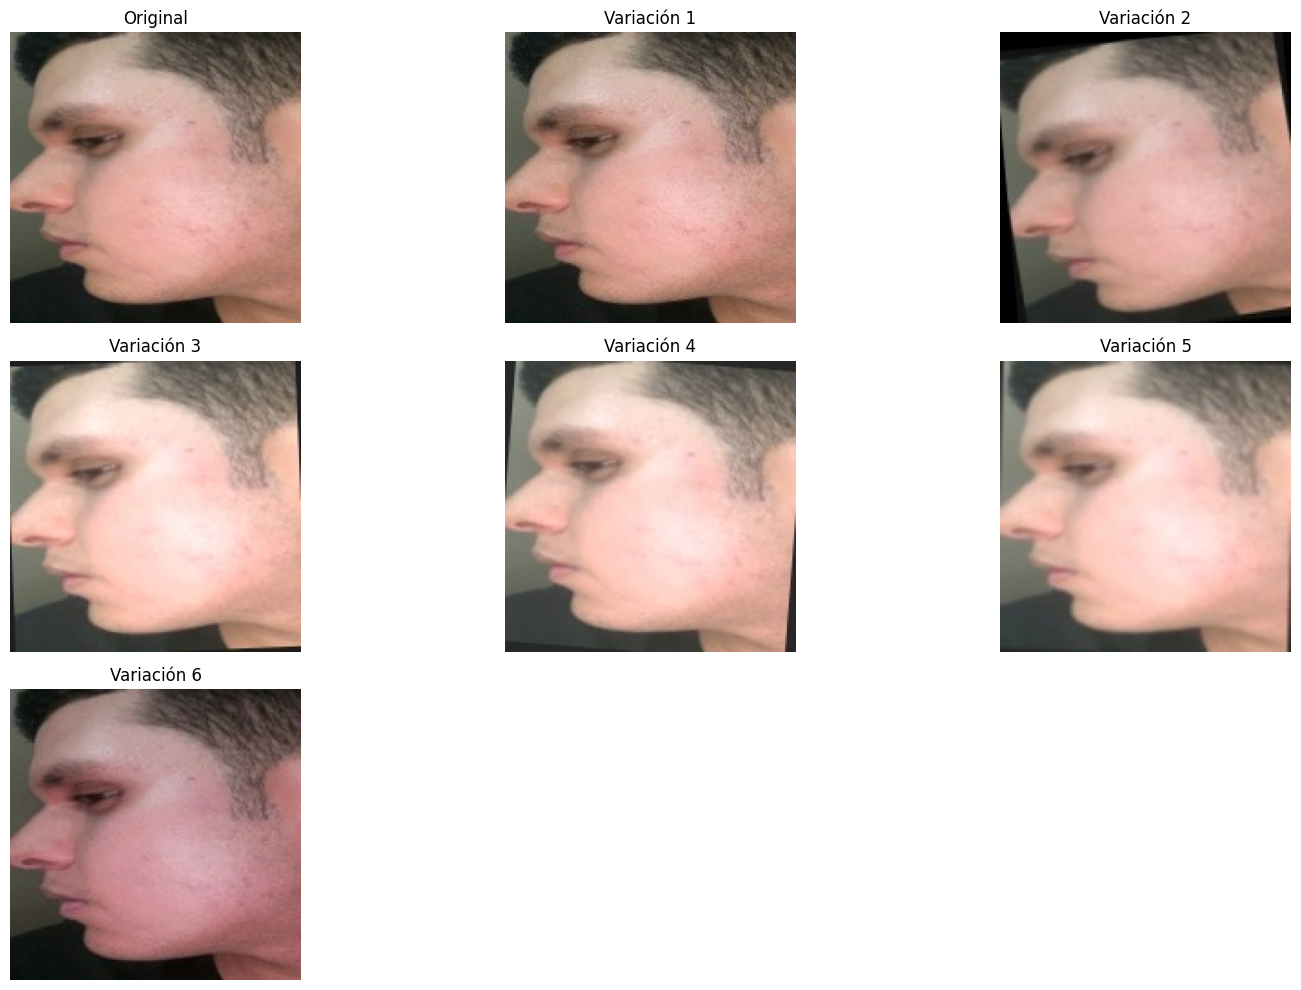

✅ Dataset procesado y listo para entrenamiento


In [17]:
# PASO 2.6: Verificar resultados
print(f"\n📋 VERIFICACIÓN DE RESULTADOS...")

# Contar archivos en cada carpeta
raw_count = len(list((data_dir / "raw").glob("*.*")))
processed_count = len(list((data_dir / "processed").glob("*.jpg")))
augmented_count = len(list((data_dir / "processed" / "augmented").glob("*.jpg")))

print(f"📁 Estructura final del dataset:")
print(f"   📂 /data/raw/: {raw_count} archivos (originales)")
print(f"   📂 /data/processed/: {processed_count} archivos (rostros detectados)")
print(f"   📂 /data/processed/augmented/: {augmented_count} archivos (variaciones)")
print(f"   🎯 Dataset total: {processed_count + augmented_count} imágenes")

# Mostrar algunas variaciones como ejemplo
if augmented_count > 0:
    print(f"\n🖼️  MOSTRANDO EJEMPLO DE VARIACIONES:")

    # Cargar imagen original y algunas variaciones
    rostro_original = Image.open(data_dir / "processed" / rostros_detectados[0])
    variaciones_ejemplo = list((data_dir / "processed" / "augmented").glob("face_001_aug_*.jpg"))[:6]

    plt.figure(figsize=(15, 10))

    # Mostrar original
    plt.subplot(3, 3, 1)
    plt.imshow(rostro_original)
    plt.title("Original")
    plt.axis('off')

    # Mostrar 6 variaciones
    for i, var_path in enumerate(variaciones_ejemplo):
        plt.subplot(3, 3, i+2)
        var_img = Image.open(var_path)
        plt.imshow(var_img)
        plt.title(f"Variación {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
print(f"✅ Dataset procesado y listo para entrenamiento")

In [18]:
# PASO 3: Extracción de embeddings y evaluación con métrica de similitud
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm

print("🔢 PASO 3: EXTRACCIÓN DE EMBEDDINGS Y EVALUACIÓN")
print("=" * 60)

# Verificar que el modelo está cargado (del Paso 1)
if 'model' not in globals():
    print("❌ Modelo no encontrado. Ejecuta primero el Paso 1")
else:
    print(f"✅ Modelo InceptionResnetV1 disponible")

🔢 PASO 3: EXTRACCIÓN DE EMBEDDINGS Y EVALUACIÓN
✅ Modelo InceptionResnetV1 disponible


In [19]:
# PASO 3.1: Configurar transformaciones para inferencia
print("\n🔧 Configurando transformaciones para inferencia...")

# Transformaciones estándar para InceptionResnetV1
transform_inference = transforms.Compose([
    transforms.Resize((160, 160)),          # Redimensionar a 160x160
    transforms.ToTensor(),                  # Convertir a tensor [0,1]
    transforms.Normalize(                   # Normalizar como espera el modelo
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

print("✅ Transformaciones configuradas")


🔧 Configurando transformaciones para inferencia...
✅ Transformaciones configuradas


In [20]:
# PASO 3.2: Función para extraer embeddings
def extraer_embedding(imagen_path, modelo, transform, device):
    """
    Extrae el embedding de una imagen usando el modelo preentrenado
    """
    try:
        # Cargar y transformar imagen
        imagen = Image.open(imagen_path).convert('RGB')
        tensor_img = transform(imagen).unsqueeze(0).to(device)

        # Extraer embedding sin gradientes
        with torch.no_grad():
            embedding = modelo(tensor_img)
            # Normalizar el embedding (importante para similitud coseno)
            embedding = F.normalize(embedding, p=2, dim=1)

        return embedding.cpu().numpy().flatten()

    except Exception as e:
        print(f"❌ Error procesando {imagen_path.name}: {str(e)}")
        return None

In [21]:
# PASO 3.3: Extraer embeddings solo de las imágenes aumentadas
print("\n🎯 EXTRAYENDO EMBEDDINGS DEL DATASET AUMENTADO...")

# Buscar solo las imágenes aumentadas
augmented_dir = data_dir / "processed" / "augmented"

if not augmented_dir.exists():
    print("❌ No se encontró la carpeta de imágenes aumentadas")
    print("Ejecuta primero el Paso 2 completo")
else:
    # Solo imágenes aumentadas
    imagenes_aumentadas = list(augmented_dir.glob("*.jpg"))

    print(f"📊 Dataset aumentado:")
    print(f"   • Total de imágenes aumentadas: {len(imagenes_aumentadas)}")

    # Extraer embeddings solo del dataset aumentado
    print(f"\n🔄 Procesando dataset aumentado...")
    embeddings_dataset = []
    nombres_dataset = []

    for img_path in tqdm(imagenes_aumentadas, desc="Extrayendo embeddings"):
        embedding = extraer_embedding(img_path, model, transform_inference, device)
        if embedding is not None:
            embeddings_dataset.append(embedding)
            nombres_dataset.append(img_path.name)

    print(f"✅ Embeddings extraídos: {len(embeddings_dataset)}/{len(imagenes_aumentadas)}")

    # Guardar embeddings para uso posterior
    embeddings_array = np.array(embeddings_dataset)
    print(f"📐 Shape de embeddings: {embeddings_array.shape}")

    # Guardar en Drive para próximos pasos
    embeddings_path = results_dir / "embeddings_dataset.npz"
    np.savez(embeddings_path,
             embeddings=embeddings_array,
             nombres=nombres_dataset)
    print(f"💾 Embeddings guardados en: {embeddings_path}")


🎯 EXTRAYENDO EMBEDDINGS DEL DATASET AUMENTADO...
📊 Dataset aumentado:
   • Total de imágenes aumentadas: 300

🔄 Procesando dataset aumentado...


Extrayendo embeddings: 100%|██████████| 300/300 [00:30<00:00,  9.80it/s]

✅ Embeddings extraídos: 300/300
📐 Shape de embeddings: (300, 512)
💾 Embeddings guardados en: /content/drive/MyDrive/Reconocimiento_Facial/results/embeddings_dataset.npz



📊 ANÁLISIS DE SIMILITUD COSENO DEL DATASET...
📈 Estadísticas de similitud:
   • Similitud promedio: 0.7700
   • Desviación estándar: 0.1460
   • Rango: [0.3622, 1.0000]
   • Número de comparaciones: 44850


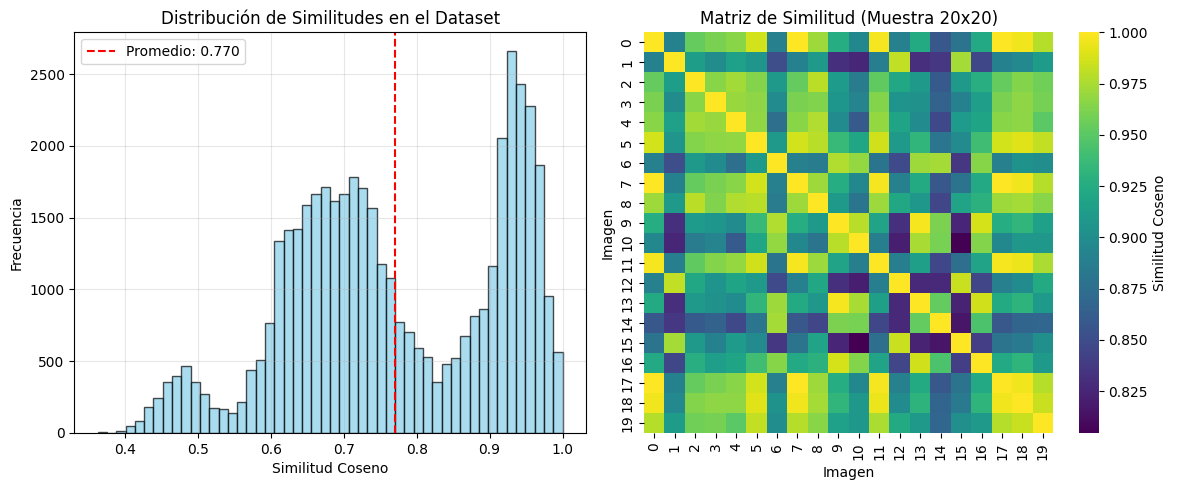

In [22]:
# PASO 3.4: Análisis de similitud coseno del dataset
print(f"\n📊 ANÁLISIS DE SIMILITUD COSENO DEL DATASET...")

# Calcular matriz de similitud coseno
similarity_matrix = cosine_similarity(embeddings_array)

# Estadísticas de similitud
upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
similitud_promedio = np.mean(upper_triangle)
similitud_std = np.std(upper_triangle)
similitud_min = np.min(upper_triangle)
similitud_max = np.max(upper_triangle)

print(f"📈 Estadísticas de similitud:")
print(f"   • Similitud promedio: {similitud_promedio:.4f}")
print(f"   • Desviación estándar: {similitud_std:.4f}")
print(f"   • Rango: [{similitud_min:.4f}, {similitud_max:.4f}]")
print(f"   • Número de comparaciones: {len(upper_triangle)}")

# Mostrar distribución de similitudes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(upper_triangle, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(similitud_promedio, color='red', linestyle='--', label=f'Promedio: {similitud_promedio:.3f}')
plt.xlabel('Similitud Coseno')
plt.ylabel('Frecuencia')
plt.title('Distribución de Similitudes en el Dataset')
plt.legend()
plt.grid(True, alpha=0.3)

# Mostrar muestra de la matriz de similitud
plt.subplot(1, 2, 2)
# Mostrar solo primeras 20x20 para visualización
sample_size = min(20, len(embeddings_dataset))
sample_matrix = similarity_matrix[:sample_size, :sample_size]
sns.heatmap(sample_matrix,
            cmap='viridis',
            cbar_kws={'label': 'Similitud Coseno'})
plt.title(f'Matriz de Similitud (Muestra {sample_size}x{sample_size})')
plt.xlabel('Imagen')
plt.ylabel('Imagen')

plt.tight_layout()


📊 ANÁLISIS PCA PARA VISUALIZACIÓN...
📐 Varianza explicada por PCA:
   • Componente 1: 0.5334
   • Componente 2: 0.1025
   • Total: 0.6359


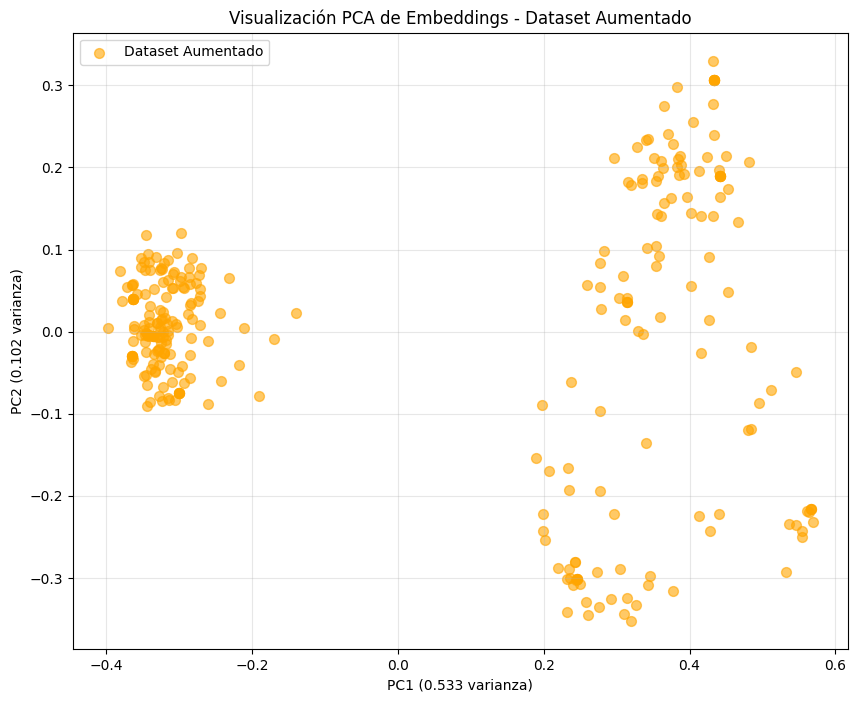

In [23]:
# PASO 3.5: Análisis PCA para visualización
print(f"\n📊 ANÁLISIS PCA PARA VISUALIZACIÓN...")

# Aplicar PCA para reducir a 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

print(f"📐 Varianza explicada por PCA:")
print(f"   • Componente 1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"   • Componente 2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"   • Total: {pca.explained_variance_ratio_.sum():.4f}")

# Visualizar en 2D
plt.figure(figsize=(10, 8))

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
           c='orange', alpha=0.6, s=50, label='Dataset Aumentado')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} varianza)')
plt.title('Visualización PCA de Embeddings - Dataset Aumentado')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
# PASO 3.6: Análisis de clusters y calidad
print(f"\n🎯 ANÁLISIS DE CALIDAD DEL DATASET...")

# Verificar que las imágenes están bien agrupadas (alta similitud interna)
print(f"✅ Evaluación de consistencia:")
if similitud_promedio > 0.8:
    print(f"   🟢 Excelente: Similitud promedio > 0.8 ({similitud_promedio:.3f})")
elif similitud_promedio > 0.7:
    print(f"   🟡 Buena: Similitud promedio > 0.7 ({similitud_promedio:.3f})")
else:
    print(f"   🔴 Mejorable: Similitud promedio < 0.7 ({similitud_promedio:.3f})")

# Variabilidad del dataset
print(f"✅ Evaluación de variabilidad:")
if similitud_std > 0.05:
    print(f"   🟢 Buena variabilidad: std = {similitud_std:.3f}")
else:
    print(f"   🟡 Poca variabilidad: std = {similitud_std:.3f}")

print(f"\n🎉 PASO 3 COMPLETADO EXITOSAMENTE!")
print(f"📊 Línea base establecida:")
print(f"   • Dataset: {len(embeddings_dataset)} imágenes")
print(f"   • Embeddings: {embeddings_array.shape[1]} dimensiones")
print(f"   • Similitud promedio: {similitud_promedio:.4f}")


🎯 ANÁLISIS DE CALIDAD DEL DATASET...
✅ Evaluación de consistencia:
   🟡 Buena: Similitud promedio > 0.7 (0.770)
✅ Evaluación de variabilidad:
   🟢 Buena variabilidad: std = 0.146

🎉 PASO 3 COMPLETADO EXITOSAMENTE!
📊 Línea base establecida:
   • Dataset: 300 imágenes
   • Embeddings: 512 dimensiones
   • Similitud promedio: 0.7700


In [25]:
# PASO 4: Fine-tuning parcial del modelo InceptionResnetV1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

In [26]:
print("🎓 PASO 4: FINE-TUNING PARCIAL DEL MODELO")
print("=" * 30)

# Verificar que el modelo está disponible
if 'model' not in globals():
    print("❌ Modelo no encontrado. Ejecuta primero el Paso 1")
else:
    print(f"✅ Modelo InceptionResnetV1 disponible para fine-tuning")

🎓 PASO 4: FINE-TUNING PARCIAL DEL MODELO
✅ Modelo InceptionResnetV1 disponible para fine-tuning


In [27]:
# PASO 4.1: Configurar el modelo para fine-tuning parcial
print("\n🔧 CONFIGURANDO FINE-TUNING PARCIAL...")

# Crear una copia del modelo para fine-tuning
model_finetuned = model  # Usar el modelo ya cargado

# Estrategia: Congelar capas iniciales, entrenar solo las finales
def configurar_finetuning_parcial(modelo):
    """
    Configura el modelo para fine-tuning parcial según la estrategia de la tesis
    """
    # Congelar todas las capas inicialmente
    for param in modelo.parameters():
        param.requires_grad = False

    # Descongelar solo las últimas capas para fine-tuning
    capas_entrenables = [
        'last_linear',           # Capa de salida
        'last_bn',              # Batch normalization final
        'repeat_3'              # Últimos bloques Inception
    ]

    params_entrenables = 0
    params_totales = 0

    for name, param in modelo.named_parameters():
        params_totales += param.numel()

        # Descongelar capas finales
        if any(capa in name for capa in capas_entrenables):
            param.requires_grad = True
            params_entrenables += param.numel()

    print(f"📊 Configuración de fine-tuning:")
    print(f"   • Parámetros totales: {params_totales:,}")
    print(f"   • Parámetros entrenables: {params_entrenables:,}")
    print(f"   • Porcentaje entrenable: {(params_entrenables/params_totales)*100:.2f}%")

    return modelo

# Configurar el modelo
model_finetuned = configurar_finetuning_parcial(model_finetuned)


🔧 CONFIGURANDO FINE-TUNING PARCIAL...
📊 Configuración de fine-tuning:
   • Parámetros totales: 27,910,327
   • Parámetros entrenables: 8,922,368
   • Porcentaje entrenable: 31.97%


In [28]:

# PASO 4.2: Preparar dataset personalizado
print("\n📊 PREPARANDO DATASET PARA FINE-TUNING...")

# ========================================
#  4.1: CREAR CLASE DATASET PERSONALIZADA
# ========================================
class FaceDataset(Dataset):
    """
    Dataset personalizado para el fine-tuning con tus imágenes

    ¿Qué hace?
    - Carga imágenes desde rutas de archivos
    - Aplica transformaciones (resize, normalización, etc.)
    - Asigna etiquetas (en tu caso, todas son clase 0 = tu rostro)
    """
    def __init__(self, image_paths, transform=None):
        """
        Constructor del dataset

        Args:
            image_paths: Lista de rutas a las imágenes
            transform: Transformaciones a aplicar (opcional)
        """
        self.image_paths = image_paths
        self.transform = transform
        # Todas las imágenes son de la misma persona (clase 0 = tu rostro)
        self.labels = [0] * len(image_paths)
        print(f"   📁 Dataset creado con {len(image_paths)} imágenes")

    def __len__(self):
        """Retorna el número total de imágenes en el dataset"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Obtiene una imagen y su etiqueta por índice

        ¿Qué pasa aquí?
        1. Carga la imagen desde el archivo
        2. Convierte a RGB (por si hay imágenes en escala de grises)
        3. Aplica transformaciones si están definidas
        4. Retorna (imagen_procesada, etiqueta)
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

print("✅ Clase FaceDataset definida")


📊 PREPARANDO DATASET PARA FINE-TUNING...
✅ Clase FaceDataset definida


In [29]:
# ========================================
# 4.2: DEFINIR TRANSFORMACIONES
# ========================================
print("\n🔧 Definiendo transformaciones...")

# TRANSFORMACIONES PARA ENTRENAMIENTO
# (Con augmentación leve para crear más variabilidad)
transform_train = transforms.Compose([
    # 1. Redimensionar a 160x160 (tamaño requerido por InceptionResnetV1)
    transforms.Resize((160, 160)),

    # 2. Augmentaciones LEVES (no queremos distorsionar mucho)
    transforms.RandomHorizontalFlip(p=0.3),        # 30% probabilidad de espejo
    transforms.RandomRotation(degrees=5),          # Rotación máxima ±5 grados
    transforms.ColorJitter(                        # Pequeños cambios de color
        brightness=0.1,    # ±10% brillo
        contrast=0.1       # ±10% contraste
    ),

    # 3. Convertir a tensor PyTorch [0,1]
    transforms.ToTensor(),

    # 4. Normalizar a [-1,1] como espera InceptionResnetV1
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# TRANSFORMACIONES PARA VALIDACIÓN
# (SIN augmentación - queremos evaluar con imágenes "normales")
transform_val = transforms.Compose([
    # Solo las transformaciones esenciales
    transforms.Resize((160, 160)),                 # Redimensionar
    transforms.ToTensor(),                         # A tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar
])

print("   ✅ Transformaciones de entrenamiento definidas (CON augmentación)")
print("   ✅ Transformaciones de validación definidas (SIN augmentación)")


🔧 Definiendo transformaciones...
   ✅ Transformaciones de entrenamiento definidas (CON augmentación)
   ✅ Transformaciones de validación definidas (SIN augmentación)


In [30]:
# ========================================
# 4.3: ORGANIZAR IMÁGENES EN TRAIN/VAL
# ========================================

# Organizar imágenes en train_test usando el directorio creado en Paso 1
print("\n📁 ORGANIZANDO DATASET EN TRAIN/TEST...")

# Directorios de entrenamiento y validación
train_dir = data_dir / "train_test" / "train"
val_dir = data_dir / "train_test" / "val"

# Crear subdirectorios si no existen
train_dir.mkdir(parents=True, exist_ok=True)
val_dir.mkdir(parents=True, exist_ok=True)

# Cargar todas las imágenes aumentadas
augmented_dir = data_dir / "processed" / "augmented"
imagenes_aumentadas = list(augmented_dir.glob("*.jpg"))

print(f"📸 Total de imágenes para organizar: {len(imagenes_aumentadas)}")

# Verificar si ya están organizadas
train_existentes = list(train_dir.glob("*.jpg"))
val_existentes = list(val_dir.glob("*.jpg"))

if len(train_existentes) == 0 and len(val_existentes) == 0:
    print("📋 Organizando imágenes por primera vez...")

    # División 80/20 para entrenamiento/validación
    random.shuffle(imagenes_aumentadas)
    split_idx = int(0.8 * len(imagenes_aumentadas))

    train_images = imagenes_aumentadas[:split_idx]
    val_images = imagenes_aumentadas[split_idx:]

    # Copiar archivos a directorios correspondientes
    import shutil

    print("📂 Copiando a directorio de entrenamiento...")
    for img_path in tqdm(train_images, desc="Train"):
        shutil.copy2(img_path, train_dir / img_path.name)

    print("📂 Copiando a directorio de validación...")
    for img_path in tqdm(val_images, desc="Val"):
        shutil.copy2(img_path, val_dir / img_path.name)

    print(f"✅ Organización completada:")
    print(f"   • Entrenamiento: {len(train_images)} imágenes")
    print(f"   • Validación: {len(val_images)} imágenes")
else:
    print("✅ Imágenes ya organizadas:")
    print(f"   • Entrenamiento: {len(train_existentes)} imágenes")
    print(f"   • Validación: {len(val_existentes)} imágenes")

# Usar imágenes de los directorios organizados
train_paths = list(train_dir.glob("*.jpg"))
val_paths = list(val_dir.glob("*.jpg"))

print(f"\n📊 Dataset final organizado:")
print(f"   • Entrenamiento: {len(train_paths)} imágenes ({len(train_paths)/len(imagenes_aumentadas)*100:.1f}%)")
print(f"   • Validación: {len(val_paths)} imágenes ({len(val_paths)/len(imagenes_aumentadas)*100:.1f}%)")


📁 ORGANIZANDO DATASET EN TRAIN/TEST...
📸 Total de imágenes para organizar: 300
📋 Organizando imágenes por primera vez...
📂 Copiando a directorio de entrenamiento...


Train: 100%|██████████| 240/240 [00:02<00:00, 101.09it/s]


📂 Copiando a directorio de validación...


Val: 100%|██████████| 60/60 [00:00<00:00, 101.32it/s]

✅ Organización completada:
   • Entrenamiento: 240 imágenes
   • Validación: 60 imágenes

📊 Dataset final organizado:
   • Entrenamiento: 240 imágenes (80.0%)
   • Validación: 60 imágenes (20.0%)


In [31]:
# ========================================
# 4.4: CREAR DATASETS Y DATALOADERS
# ========================================
print("\n📦 Creando datasets y dataloaders...")

# Crear datasets usando nuestras rutas organizadas
print("   🔄 Creando dataset de entrenamiento...")
train_dataset = FaceDataset(train_paths, transform=transform_train)

print("   🔄 Creando dataset de validación...")
val_dataset = FaceDataset(val_paths, transform=transform_val)

# ¿Qué es un DataLoader?
# Es un "alimentador" que:
# 1. Toma imágenes del dataset en grupos (batches)
# 2. Las mezcla (shuffle) para entrenamiento
# 3. Las entrega al modelo de forma eficiente

batch_size = 16  # Procesar 16 imágenes a la vez

print(f"   🔄 Creando DataLoader de entrenamiento (batch_size={batch_size})...")
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,    # Mezclar orden para mejor entrenamiento
    num_workers=0    # Sin workers paralelos (para evitar problemas en Colab)
)

print(f"   🔄 Creando DataLoader de validación (batch_size={batch_size})...")
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,   # NO mezclar en validación (queremos orden consistente)
    num_workers=0
)

print(f"\n📊 RESUMEN DEL DATASET:")
print(f"   • Dataset de entrenamiento: {len(train_dataset)} imágenes")
print(f"   • Dataset de validación: {len(val_dataset)} imágenes")
print(f"   • Batches de entrenamiento: {len(train_loader)} batches")
print(f"   • Batches de validación: {len(val_loader)} batches")
print(f"   • Tamaño de batch: {batch_size} imágenes por batch")

# ========================================
# VERIFICACIÓN: ¿FUNCIONA CORRECTAMENTE?
# ========================================
print(f"\n🔍 VERIFICANDO QUE TODO FUNCIONE...")

# Probar cargar un batch de entrenamiento
try:
    sample_batch_train = next(iter(train_loader))
    images, labels = sample_batch_train
    print(f"   ✅ Batch de entrenamiento cargado exitosamente:")
    print(f"      • Shape de imágenes: {images.shape}")  # Debería ser [batch_size, 3, 160, 160]
    print(f"      • Shape de etiquetas: {labels.shape}")  # Debería ser [batch_size]
    print(f"      • Rango de valores: [{images.min():.2f}, {images.max():.2f}]")  # Debería ser [-1, 1]

except Exception as e:
    print(f"   ❌ Error cargando batch de entrenamiento: {e}")

# Probar cargar un batch de validación
try:
    sample_batch_val = next(iter(val_loader))
    images, labels = sample_batch_val
    print(f"   ✅ Batch de validación cargado exitosamente:")
    print(f"      • Shape de imágenes: {images.shape}")
    print(f"      • Shape de etiquetas: {labels.shape}")

except Exception as e:
    print(f"   ❌ Error cargando batch de validación: {e}")


📦 Creando datasets y dataloaders...
   🔄 Creando dataset de entrenamiento...
   📁 Dataset creado con 240 imágenes
   🔄 Creando dataset de validación...
   📁 Dataset creado con 60 imágenes
   🔄 Creando DataLoader de entrenamiento (batch_size=16)...
   🔄 Creando DataLoader de validación (batch_size=16)...

📊 RESUMEN DEL DATASET:
   • Dataset de entrenamiento: 240 imágenes
   • Dataset de validación: 60 imágenes
   • Batches de entrenamiento: 15 batches
   • Batches de validación: 4 batches
   • Tamaño de batch: 16 imágenes por batch

🔍 VERIFICANDO QUE TODO FUNCIONE...
   ✅ Batch de entrenamiento cargado exitosamente:
      • Shape de imágenes: torch.Size([16, 3, 160, 160])
      • Shape de etiquetas: torch.Size([16])
      • Rango de valores: [-1.00, 1.00]
   ✅ Batch de validación cargado exitosamente:
      • Shape de imágenes: torch.Size([16, 3, 160, 160])
      • Shape de etiquetas: torch.Size([16])


In [32]:
# PASO 4.3: Configurar pérdida y optimizador
print("\n⚙️ CONFIGURANDO ENTRENAMIENTO...")

# Función de pérdida: Triplet Loss para embeddings
class TripletLoss(nn.Module):
    def __init__(self, margin=0.3):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        # Calcular todas las distancias
        distances = torch.cdist(embeddings, embeddings, p=2)

        # Máscara para pares positivos (misma etiqueta)
        same_label_mask = labels.unsqueeze(0) == labels.unsqueeze(1)

        # Máscara para pares negativos (diferente etiqueta)
        diff_label_mask = ~same_label_mask

        # Distancia promedio positiva (misma persona)
        positive_distances = distances[same_label_mask]
        if len(positive_distances) > 0:
            avg_positive = positive_distances.mean()
        else:
            avg_positive = torch.tensor(0.0, device=embeddings.device)

        # Para este caso (una sola persona), usamos regularización de compacidad
        loss = avg_positive  # Minimizar distancia entre embeddings de la misma persona

        return loss

# Configurar optimizador con tasa de aprendizaje baja (fine-tuning)
criterion = TripletLoss(margin=0.3)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_finetuned.parameters()),
    lr=0.0001,  # Tasa de aprendizaje baja para fine-tuning
    weight_decay=1e-4
)

# Scheduler para reducir learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

print(f"✅ Configuración de entrenamiento:")
print(f"   • Función de pérdida: TripletLoss (margin=0.3)")
print(f"   • Optimizador: Adam (lr=0.0001)")
print(f"   • Scheduler: StepLR")


⚙️ CONFIGURANDO ENTRENAMIENTO...
✅ Configuración de entrenamiento:
   • Función de pérdida: TripletLoss (margin=0.3)
   • Optimizador: Adam (lr=0.0001)
   • Scheduler: StepLR


In [33]:
# PASO 4.4: Función de entrenamiento
def entrenar_epoca(modelo, train_loader, criterion, optimizer, device):
    """
    Entrena una época del modelo
    """
    modelo.train()
    total_loss = 0.0
    num_batches = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Entrenando")):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        embeddings = modelo(images)

        # Calcular pérdida
        loss = criterion(embeddings, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

def validar_epoca(modelo, val_loader, criterion, device):
    """
    Valida una época del modelo
    """
    modelo.eval()
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validando"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            embeddings = modelo(images)

            # Calcular pérdida
            loss = criterion(embeddings, labels)

            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches

In [34]:
#PASO 4.5: Entrenamiento del modelo
print("\n🚀 INICIANDO FINE-TUNING...")

# Configuración del entrenamiento
num_epochs = 20
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Mover modelo al dispositivo
model_finetuned = model_finetuned.to(device)

# DEBUGGING DEL LEARNING RATE - Agregar antes del bucle
print("\n🔍 DEBUGGING LEARNING RATE:")
print(f"LR inicial configurado: 0.0001")
print(f"LR actual en optimizer: {optimizer.param_groups[0]['lr']:.8f}")
print(f"Scheduler step_size: {scheduler.step_size}")
print(f"Scheduler gamma: {scheduler.gamma}")
print(f"Scheduler last_epoch: {scheduler.last_epoch}")
# Verificar si ya se ejecutó scheduler antes
print(f"¿Ya se ejecutó scheduler? {scheduler.last_epoch > -1}")

# REINICIAR SCHEDULER PARA EMPEZAR LIMPIO
print("\n🔄 REINICIANDO SCHEDULER...")
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
print(f"✅ Scheduler reiniciado")
print(f"   • Nuevo last_epoch: {scheduler.last_epoch}")
print(f"   • LR actual: {optimizer.param_groups[0]['lr']:.8f}")

print(f"\n🎯 Entrenando por {num_epochs} épocas...")
print(f"📱 Dispositivo: {device}")

for epoch in range(num_epochs):
    print(f"\n📍 Época {epoch+1}/{num_epochs}")

    # Mostrar learning rate ANTES del entrenamiento
    current_lr = optimizer.param_groups[0]['lr']
    print(f"   📊 Learning Rate: {current_lr:.8f}")

    # Entrenar
    train_loss = entrenar_epoca(model_finetuned, train_loader, criterion, optimizer, device)

    # Validar
    val_loss = validar_epoca(model_finetuned, val_loader, criterion, device)

    # Guardar métricas
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Imprimir progreso
    print(f"   📊 Train Loss: {train_loss:.6f}")
    print(f"   📊 Val Loss: {val_loss:.6f}")

    # Actualizar scheduler SOLO cada 10 épocas
    if (epoch + 1) % 10 == 0:
        scheduler.step()
        new_lr = optimizer.param_groups[0]['lr']
        print(f"   🔄 Learning Rate reducido a: {new_lr:.8f}")

    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_path = models_dir / "inception_resnet_v1_finetuned.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_finetuned.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': {
                'fine_tuning_type': 'partial',
                'learning_rate': 0.0001,
                'batch_size': batch_size,
                'num_epochs': num_epochs
            }
        }, best_model_path)
        print(f"   💾 Mejor modelo guardado (val_loss: {val_loss:.6f})")

print(f"\n🎉 FINE-TUNING COMPLETADO!")
print(f"✅ Mejor pérdida de validación: {best_val_loss:.6f}")
print(f"💾 Modelo guardado en: {best_model_path}")


🚀 INICIANDO FINE-TUNING...

🔍 DEBUGGING LEARNING RATE:
LR inicial configurado: 0.0001
LR actual en optimizer: 0.00010000
Scheduler step_size: 10
Scheduler gamma: 0.7
Scheduler last_epoch: 0
¿Ya se ejecutó scheduler? True

🔄 REINICIANDO SCHEDULER...
✅ Scheduler reiniciado
   • Nuevo last_epoch: 0
   • LR actual: 0.00010000

🎯 Entrenando por 20 épocas...
📱 Dispositivo: cpu

📍 Época 1/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


   📊 Train Loss: 1.262338
   📊 Val Loss: 1.032206
   💾 Mejor modelo guardado (val_loss: 1.032206)

📍 Época 2/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


   📊 Train Loss: 1.133323
   📊 Val Loss: 0.918447
   💾 Mejor modelo guardado (val_loss: 0.918447)

📍 Época 3/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


   📊 Train Loss: 0.892106
   📊 Val Loss: 0.556312
   💾 Mejor modelo guardado (val_loss: 0.556312)

📍 Época 4/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


   📊 Train Loss: 0.537320
   📊 Val Loss: 0.480664
   💾 Mejor modelo guardado (val_loss: 0.480664)

📍 Época 5/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


   📊 Train Loss: 0.458030
   📊 Val Loss: 0.592614

📍 Época 6/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


   📊 Train Loss: 0.401509
   📊 Val Loss: 0.168978
   💾 Mejor modelo guardado (val_loss: 0.168978)

📍 Época 7/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


   📊 Train Loss: 0.338098
   📊 Val Loss: 0.150794
   💾 Mejor modelo guardado (val_loss: 0.150794)

📍 Época 8/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


   📊 Train Loss: 0.358010
   📊 Val Loss: 0.416080

📍 Época 9/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


   📊 Train Loss: 0.327656
   📊 Val Loss: 0.288667

📍 Época 10/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


   📊 Train Loss: 0.312391
   📊 Val Loss: 0.201080
   🔄 Learning Rate reducido a: 0.00010000

📍 Época 11/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


   📊 Train Loss: 0.314717
   📊 Val Loss: 0.290437

📍 Época 12/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


   📊 Train Loss: 0.296394
   📊 Val Loss: 0.130831
   💾 Mejor modelo guardado (val_loss: 0.130831)

📍 Época 13/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


   📊 Train Loss: 0.306922
   📊 Val Loss: 0.129360
   💾 Mejor modelo guardado (val_loss: 0.129360)

📍 Época 14/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


   📊 Train Loss: 0.279728
   📊 Val Loss: 0.279017

📍 Época 15/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


   📊 Train Loss: 0.273549
   📊 Val Loss: 0.126383
   💾 Mejor modelo guardado (val_loss: 0.126383)

📍 Época 16/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


   📊 Train Loss: 0.275122
   📊 Val Loss: 0.022664
   💾 Mejor modelo guardado (val_loss: 0.022664)

📍 Época 17/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


   📊 Train Loss: 0.285508
   📊 Val Loss: 0.023954

📍 Época 18/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


   📊 Train Loss: 0.334923
   📊 Val Loss: 0.987250

📍 Época 19/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


   📊 Train Loss: 0.406969
   📊 Val Loss: 0.651718

📍 Época 20/20
   📊 Learning Rate: 0.00010000


Validando: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

   📊 Train Loss: 0.392054
   📊 Val Loss: 0.186545
   🔄 Learning Rate reducido a: 0.00010000

🎉 FINE-TUNING COMPLETADO!
✅ Mejor pérdida de validación: 0.022664
💾 Modelo guardado en: /content/drive/MyDrive/Reconocimiento_Facial/models/inception_resnet_v1_finetuned.pth



📊 VISUALIZANDO RESULTADOS...


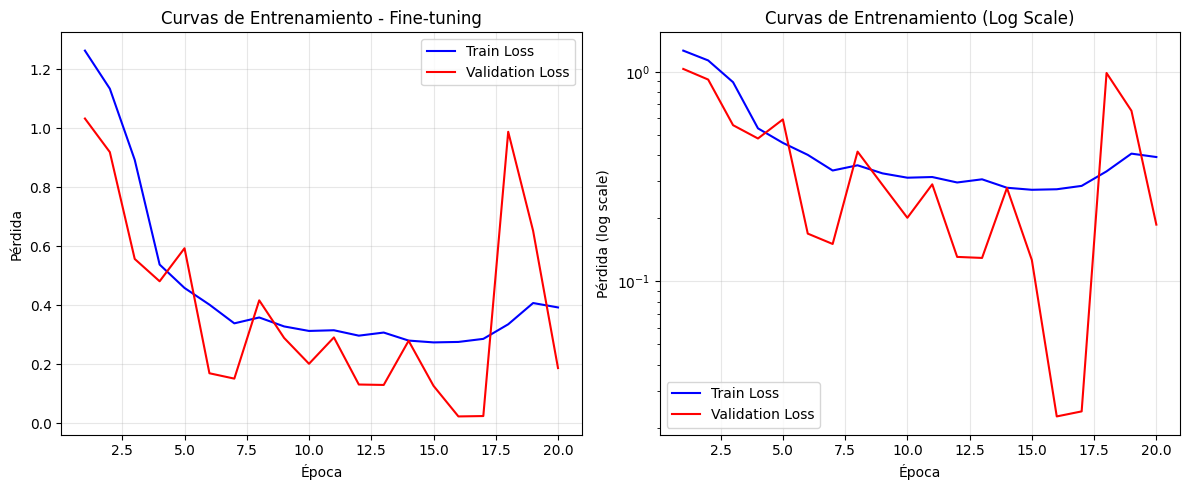


🎯 ANÁLISIS DETALLADO DE RESULTADOS:
   • Pérdida final de entrenamiento: 0.392054
   • Pérdida final de validación: 0.186545
   • Mejora durante entrenamiento: 68.94%

🏆 MEJORES RESULTADOS OBTENIDOS:
   • Mejor Train Loss: 0.273549 (Época 15)
   • Mejor Val Loss: 0.022664 (Época 16)
   • Modelo guardado corresponde a: Época 16 (mejor val_loss)


In [35]:
# PASO 4.6: Visualizar resultados del entrenamiento
print("\n📊 VISUALIZANDO RESULTADOS...")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curvas de Entrenamiento - Fine-tuning')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida (log scale)')
plt.title('Curvas de Entrenamiento (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Encontrar mejores épocas
mejor_train_epoch = np.argmin(train_losses) + 1
mejor_val_epoch = np.argmin(val_losses) + 1
mejor_train_loss = min(train_losses)
mejor_val_loss = min(val_losses)

print(f"\n🎯 ANÁLISIS DETALLADO DE RESULTADOS:")
print(f"   • Pérdida final de entrenamiento: {train_losses[-1]:.6f}")
print(f"   • Pérdida final de validación: {val_losses[-1]:.6f}")
print(f"   • Mejora durante entrenamiento: {((train_losses[0] - train_losses[-1])/train_losses[0]*100):.2f}%")

print(f"\n🏆 MEJORES RESULTADOS OBTENIDOS:")
print(f"   • Mejor Train Loss: {mejor_train_loss:.6f} (Época {mejor_train_epoch})")
print(f"   • Mejor Val Loss: {mejor_val_loss:.6f} (Época {mejor_val_epoch})")
print(f"   • Modelo guardado corresponde a: Época {mejor_val_epoch} (mejor val_loss)")

In [44]:
# PASO 5: Entrenamiento y evaluación de clasificador
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm

In [46]:
print("🎯 PASO 5: EVALUACIÓN DEL MODELO FINE-TUNEADO")
print("=" * 60)

# PASO 5.1: Cargar el modelo fine-tuneado
print("\n🔄 CARGANDO MODELO FINE-TUNEADO...")

# Verificar que el modelo base existe
if 'model' not in globals():
    print("❌ Modelo base no encontrado. Ejecuta primero el Paso 1")
else:
    # Cargar el modelo fine-tuneado
    model_path = models_dir / "inception_resnet_v1_finetuned.pth"

    if model_path.exists():
        print(f"📁 Cargando desde: {model_path}")

        # Cargar checkpoint
        checkpoint = torch.load(model_path, map_location=device)

        # Crear modelo y cargar pesos
        model_finetuned = model  # Usar el modelo base
        model_finetuned.load_state_dict(checkpoint['model_state_dict'])
        model_finetuned = model_finetuned.to(device)
        model_finetuned.eval()

        print(f"✅ Modelo fine-tuneado cargado exitosamente")
        print(f"   • Train loss final: {checkpoint['train_loss']:.6f}")
        print(f"   • Val loss final: {checkpoint['val_loss']:.6f}")

    else:
        print("❌ Modelo fine-tuneado no encontrado. Ejecuta primero el Paso 4")

🎯 PASO 5: EVALUACIÓN DEL MODELO FINE-TUNEADO

🔄 CARGANDO MODELO FINE-TUNEADO...
📁 Cargando desde: /content/drive/MyDrive/Reconocimiento_Facial/models/inception_resnet_v1_finetuned.pth
✅ Modelo fine-tuneado cargado exitosamente
   • Train loss final: 0.275122
   • Val loss final: 0.022664


In [47]:
# PASO 5.2: Configurar transformaciones para evaluación
print("\n🔧 CONFIGURANDO EVALUACIÓN...")

# Transformaciones estándar (sin augmentación para evaluación justa)
transform_eval = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Función para extraer embeddings con modelo fine-tuneado
def extraer_embedding_finetuned(imagen_path, modelo, transform, device):
    """
    Extrae embedding usando el modelo fine-tuneado
    """
    try:
        imagen = Image.open(imagen_path).convert('RGB')
        tensor_img = transform(imagen).unsqueeze(0).to(device)

        with torch.no_grad():
            embedding = modelo(tensor_img)
            embedding = F.normalize(embedding, p=2, dim=1)

        return embedding.cpu().numpy().flatten()

    except Exception as e:
        print(f"❌ Error procesando {imagen_path.name}: {str(e)}")
        return None

print("✅ Configuración de evaluación lista")


🔧 CONFIGURANDO EVALUACIÓN...
✅ Configuración de evaluación lista


In [48]:
# PASO 5.3: Extraer embeddings con modelo fine-tuneado
print("\n🎯 EXTRAYENDO EMBEDDINGS CON MODELO FINE-TUNEADO...")

# Usar el conjunto de validación para evaluación
val_dir = data_dir / "train_test" / "val"
val_images = list(val_dir.glob("*.jpg"))

print(f"📊 Evaluando con {len(val_images)} imágenes de validación")

# Extraer embeddings con modelo fine-tuneado
embeddings_finetuned = []
nombres_val = []

for img_path in tqdm(val_images, desc="Embeddings fine-tuned"):
    embedding = extraer_embedding_finetuned(img_path, model_finetuned, transform_eval, device)
    if embedding is not None:
        embeddings_finetuned.append(embedding)
        nombres_val.append(img_path.name)

embeddings_finetuned = np.array(embeddings_finetuned)
print(f"✅ Embeddings extraídos: {len(embeddings_finetuned)} de {len(val_images)}")


🎯 EXTRAYENDO EMBEDDINGS CON MODELO FINE-TUNEADO...
📊 Evaluando con 60 imágenes de validación


Embeddings fine-tuned: 100%|██████████| 60/60 [00:06<00:00,  9.06it/s]

✅ Embeddings extraídos: 60 de 60


In [49]:

# PASO 5.4: Comparar con embeddings del modelo base (Paso 3)
print("\n📊 COMPARANDO CON MODELO BASE...")

# Cargar embeddings del modelo base (del Paso 3)
embeddings_base_path = results_dir / "embeddings_dataset.npz"

if embeddings_base_path.exists():
    # Cargar embeddings base
    data_base = np.load(embeddings_base_path)
    embeddings_base = data_base['embeddings']
    nombres_base = data_base['nombres']

    print(f"📊 Embeddings base cargados: {len(embeddings_base)} imágenes")

    # Tomar una muestra del modelo base para comparación justa
    if len(embeddings_base) > len(embeddings_finetuned):
        indices_muestra = np.random.choice(len(embeddings_base), len(embeddings_finetuned), replace=False)
        embeddings_base_muestra = embeddings_base[indices_muestra]
    else:
        embeddings_base_muestra = embeddings_base

    print(f"📊 Muestra del modelo base: {len(embeddings_base_muestra)} imágenes")

else:
    print("⚠️  Embeddings base no encontrados. Saltando comparación")
    embeddings_base_muestra = None


📊 COMPARANDO CON MODELO BASE...
📊 Embeddings base cargados: 300 imágenes
📊 Muestra del modelo base: 60 imágenes


In [50]:
# PASO 5.5: Análisis de similitud mejorado
print("\n🔍 ANÁLISIS DE SIMILITUD - MODELO FINE-TUNEADO...")

# Calcular matriz de similitud para modelo fine-tuneado
similarity_matrix_ft = cosine_similarity(embeddings_finetuned)

# Estadísticas del modelo fine-tuneado
upper_triangle_ft = similarity_matrix_ft[np.triu_indices_from(similarity_matrix_ft, k=1)]
similitud_promedio_ft = np.mean(upper_triangle_ft)
similitud_std_ft = np.std(upper_triangle_ft)
similitud_min_ft = np.min(upper_triangle_ft)
similitud_max_ft = np.max(upper_triangle_ft)

print(f"🎯 MODELO FINE-TUNEADO:")
print(f"   • Similitud promedio: {similitud_promedio_ft:.4f}")
print(f"   • Desviación estándar: {similitud_std_ft:.4f}")
print(f"   • Rango: [{similitud_min_ft:.4f}, {similitud_max_ft:.4f}]")

# Comparar con modelo base si está disponible
mejora_similitud = None
if embeddings_base_muestra is not None:
    similarity_matrix_base = cosine_similarity(embeddings_base_muestra)
    upper_triangle_base = similarity_matrix_base[np.triu_indices_from(similarity_matrix_base, k=1)]
    similitud_promedio_base = np.mean(upper_triangle_base)
    similitud_std_base = np.std(upper_triangle_base)

    print(f"\n📊 COMPARACIÓN CON MODELO BASE:")
    print(f"   🔵 Modelo Base:")
    print(f"      • Similitud promedio: {similitud_promedio_base:.4f}")
    print(f"      • Desviación estándar: {similitud_std_base:.4f}")

    print(f"   🟢 Modelo Fine-tuneado:")
    print(f"      • Similitud promedio: {similitud_promedio_ft:.4f}")
    print(f"      • Desviación estándar: {similitud_std_ft:.4f}")

    # Calcular mejora
    mejora_similitud = ((similitud_promedio_ft - similitud_promedio_base) / similitud_promedio_base) * 100
    print(f"\n🚀 MEJORA:")
    print(f"   • Incremento en similitud: {mejora_similitud:+.2f}%")

    if mejora_similitud > 0:
        print(f"   ✅ El fine-tuning MEJORÓ el reconocimiento")
    else:
        print(f"   ⚠️  El fine-tuning redujo la similitud (posible overfitting)")


🔍 ANÁLISIS DE SIMILITUD - MODELO FINE-TUNEADO...
🎯 MODELO FINE-TUNEADO:
   • Similitud promedio: 0.9996
   • Desviación estándar: 0.0007
   • Rango: [0.9958, 1.0000]

📊 COMPARACIÓN CON MODELO BASE:
   🔵 Modelo Base:
      • Similitud promedio: 0.7745
      • Desviación estándar: 0.1520
   🟢 Modelo Fine-tuneado:
      • Similitud promedio: 0.9996
      • Desviación estándar: 0.0007

🚀 MEJORA:
   • Incremento en similitud: +29.06%
   ✅ El fine-tuning MEJORÓ el reconocimiento


In [56]:
# PASO 5.6: Métricas de clasificación
print("\n🎯 MÉTRICAS DE CLASIFICACIÓN...")

# Simular clasificación binaria: ¿Es tu rostro o no?
# Usar umbral de similitud para decidir
umbral_similitud = 0.95  # Ajustable según necesidades

# Para cada imagen, calcular similitud promedio con todas las demás
similitudes_promedio = []
for i in range(len(embeddings_finetuned)):
    # Similitud con todas las demás imágenes (excluyendo la misma)
    similitudes_con_otras = similarity_matrix_ft[i, np.arange(len(embeddings_finetuned)) != i]
    similitud_prom = np.mean(similitudes_con_otras)
    similitudes_promedio.append(similitud_prom)

similitudes_promedio = np.array(similitudes_promedio)

# Clasificación: Si similitud promedio > umbral, es "tu rostro"
predicciones = (similitudes_promedio > umbral_similitud).astype(int)
etiquetas_reales = np.ones(len(embeddings_finetuned))  # Todas son tu rostro

# Calcular métricas
accuracy = accuracy_score(etiquetas_reales, predicciones)
precision = precision_score(etiquetas_reales, predicciones, zero_division=1)
recall = recall_score(etiquetas_reales, predicciones, zero_division=1)
f1 = f1_score(etiquetas_reales, predicciones, zero_division=1)

print(f"📊 MÉTRICAS DE CLASIFICACIÓN (umbral={umbral_similitud}):")
print(f"   • Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   • Precision: {precision:.4f}")
print(f"   • Recall: {recall:.4f}")
print(f"   • F1-Score: {f1:.4f}")


🎯 MÉTRICAS DE CLASIFICACIÓN...
📊 MÉTRICAS DE CLASIFICACIÓN (umbral=0.95):
   • Accuracy: 1.0000 (100.00%)
   • Precision: 1.0000
   • Recall: 1.0000
   • F1-Score: 1.0000



📊 GENERANDO VISUALIZACIONES...
📊 Gráfico 1: Comparación de distribuciones...


/tmp/ipython-input-61-3495723598.py:53: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


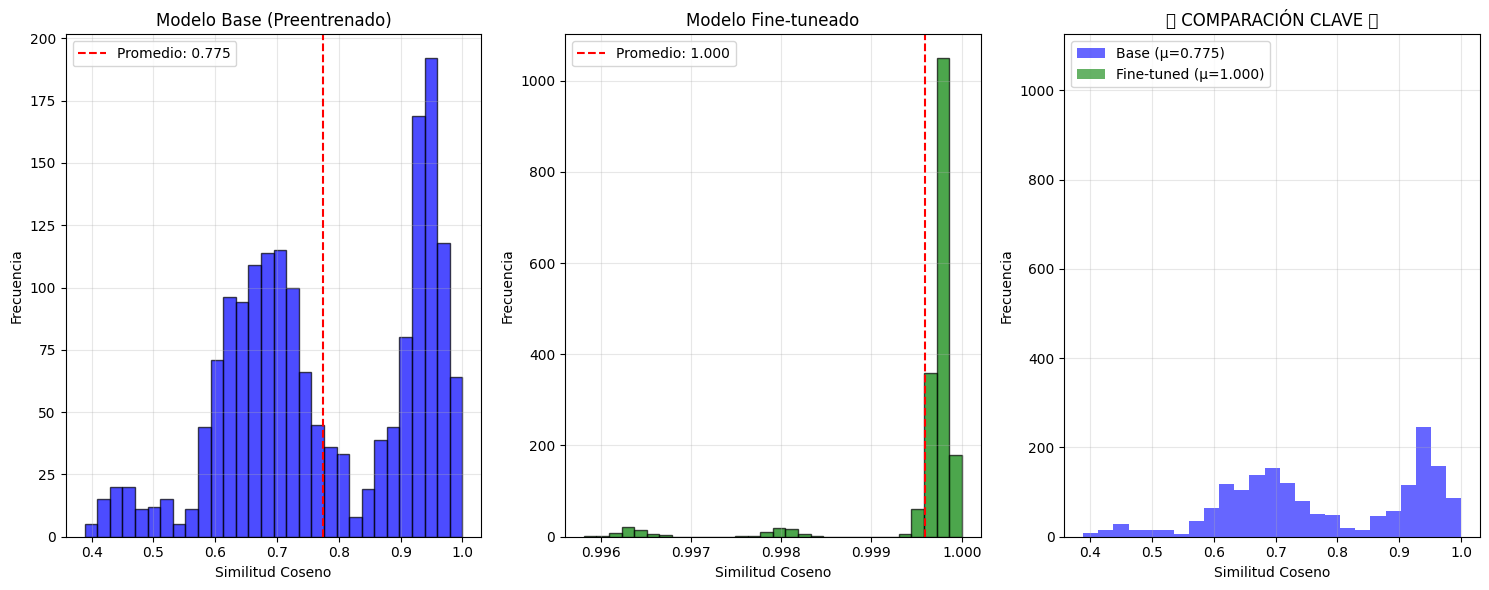

📊 Gráfico 2: Matriz de similitud del modelo base...


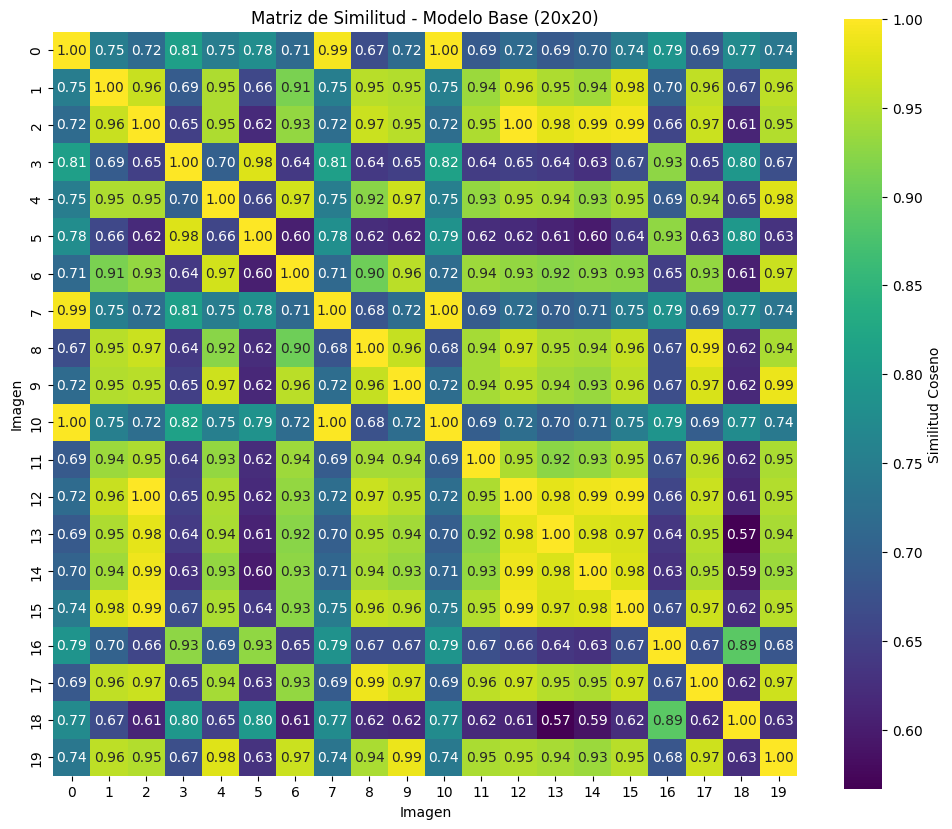

📊 Gráfico 3: Matriz de similitud del modelo fine-tuneado...


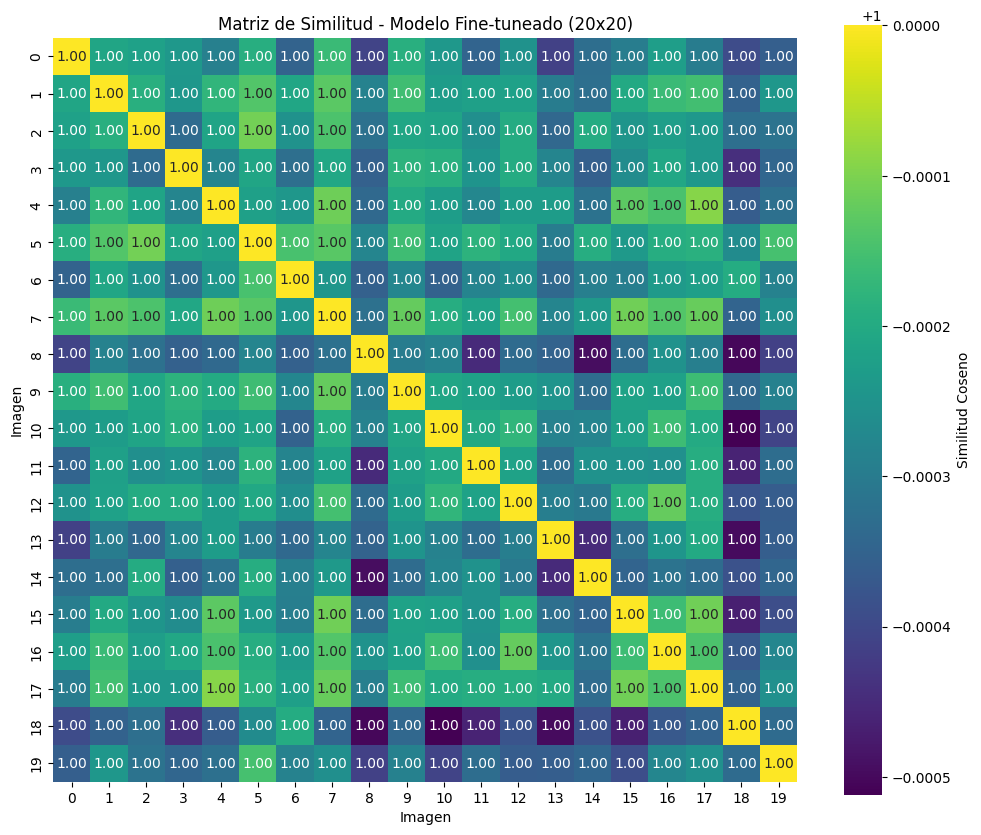

📊 Gráfico 3: Diferencia entre modelos...


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


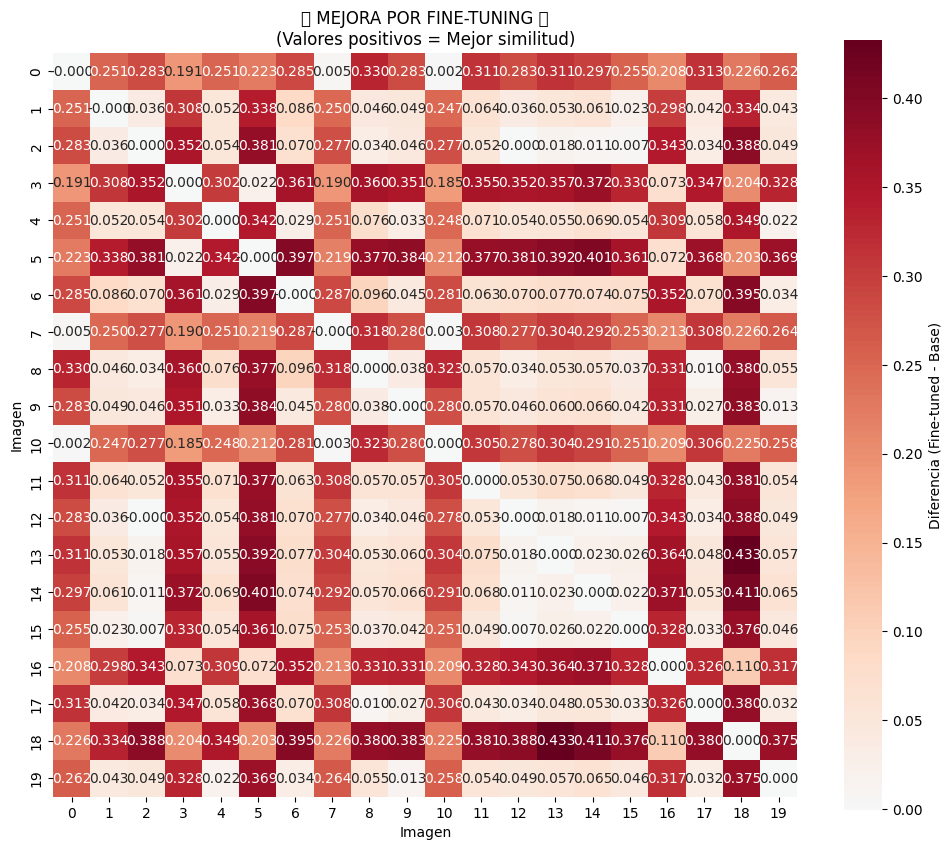

<Figure size 640x480 with 0 Axes>

In [61]:
# PASO 5.7: Visualización de resultados
print("\n📊 GENERANDO VISUALIZACIONES...")

# ========================================
# GRÁFICO 1: COMPARACIÓN DE DISTRIBUCIONES (MÁS IMPORTANTE)
# ========================================
print("📊 Gráfico 1: Comparación de distribuciones...")
plt.figure(figsize=(15, 6))

if embeddings_base_muestra is not None:
    plt.subplot(1, 3, 1)
    plt.hist(upper_triangle_base, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(similitud_promedio_base, color='red', linestyle='--',
                label=f'Promedio: {similitud_promedio_base:.3f}')
    plt.xlabel('Similitud Coseno')
    plt.ylabel('Frecuencia')
    plt.title('Modelo Base (Preentrenado)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.hist(upper_triangle_ft, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(similitud_promedio_ft, color='red', linestyle='--',
                label=f'Promedio: {similitud_promedio_ft:.3f}')
    plt.xlabel('Similitud Coseno')
    plt.ylabel('Frecuencia')
    plt.title('Modelo Fine-tuneado')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Comparación superpuesta (MÁS IMPORTANTE)
    plt.subplot(1, 3, 3)
    plt.hist(upper_triangle_base, bins=25, alpha=0.6, color='blue',
             label=f'Base (μ={similitud_promedio_base:.3f})')
    plt.hist(upper_triangle_ft, bins=25, alpha=0.6, color='green',
             label=f'Fine-tuned (μ={similitud_promedio_ft:.3f})')
    plt.xlabel('Similitud Coseno')
    plt.ylabel('Frecuencia')
    plt.title('⭐ COMPARACIÓN CLAVE ⭐')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.subplot(1, 1, 1)
    plt.hist(upper_triangle_ft, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(similitud_promedio_ft, color='red', linestyle='--',
                label=f'Promedio: {similitud_promedio_ft:.3f}')
    plt.xlabel('Similitud Coseno')
    plt.ylabel('Frecuencia')
    plt.title('Distribución - Modelo Fine-tuneado')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# GRÁFICO 2: MATRIZ DE SIMILITUD DEL MODELO BASE
# ========================================
if embeddings_base_muestra is not None:
    print("📊 Gráfico 2: Matriz de similitud del modelo base...")
    plt.figure(figsize=(12, 10))

    sample_size = min(20, len(embeddings_base_muestra))
    sample_matrix_base = similarity_matrix_base[:sample_size, :sample_size]

    sns.heatmap(sample_matrix_base,
                annot=True,
                fmt='.2f',  # Menos decimales para mejor legibilidad
                cmap='viridis',
                square=True,
                cbar_kws={'label': 'Similitud Coseno'})
    plt.title(f'Matriz de Similitud - Modelo Base ({sample_size}x{sample_size})')
    plt.xlabel('Imagen')
    plt.ylabel('Imagen')
    plt.show()
else:
    print("⚠️  Modelo base no disponible para mostrar matriz")

# ========================================
# GRÁFICO 3: MATRIZ DE SIMILITUD DEL MODELO FINE-TUNEADO
# ========================================
print("📊 Gráfico 3: Matriz de similitud del modelo fine-tuneado...")
plt.figure(figsize=(12, 10))

sample_size = min(20, len(embeddings_finetuned))  # Mostrar más elementos
sample_matrix_ft = similarity_matrix_ft[:sample_size, :sample_size]

sns.heatmap(sample_matrix_ft,
            annot=True,
            fmt='.2f',  # Menos decimales para mejor legibilidad
            cmap='viridis',
            square=True,
            cbar_kws={'label': 'Similitud Coseno'})
plt.title(f'Matriz de Similitud - Modelo Fine-tuneado ({sample_size}x{sample_size})')
plt.xlabel('Imagen')
plt.ylabel('Imagen')
plt.show()

# ========================================
# GRÁFICO 3: MATRIZ DE DIFERENCIAS (Solo si hay modelo base)
# ========================================
if embeddings_base_muestra is not None:
    print("📊 Gráfico 3: Diferencia entre modelos...")
    plt.figure(figsize=(12, 10))

    sample_matrix_base = similarity_matrix_base[:sample_size, :sample_size]
    diff_matrix = sample_matrix_ft - sample_matrix_base

    sns.heatmap(diff_matrix,
                annot=True,
                fmt='.3f',
                cmap='RdBu_r',
                center=0,
                square=True,
                cbar_kws={'label': 'Diferencia (Fine-tuned - Base)'})
    plt.title(f'⭐ MEJORA POR FINE-TUNING ⭐\n(Valores positivos = Mejor similitud)')
    plt.xlabel('Imagen')
    plt.ylabel('Imagen')
    plt.show()

plt.tight_layout()
plt.show()

In [64]:
import json
# PASO 5.8: Resumen final y guardado de resultados
print("\n📝 GUARDANDO RESULTADOS DE EVALUACIÓN...")

# Crear resumen de resultados
resultados_evaluacion = {
    'modelo_finetuned': {
        'similitud_promedio': float(similitud_promedio_ft),
        'similitud_std': float(similitud_std_ft),
        'similitud_min': float(similitud_min_ft),
        'similitud_max': float(similitud_max_ft),

        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'umbral_usado': float(umbral_similitud)
    }
}

if embeddings_base_muestra is not None:
    resultados_evaluacion['modelo_base'] = {
        'similitud_promedio': float(similitud_promedio_base),
        'similitud_std': float(similitud_std_base)
    }
    resultados_evaluacion['mejora_similitud_pct'] = float(mejora_similitud)

# Guardar embeddings del modelo fine-tuneado
embeddings_ft_path = results_dir / "embeddings_finetuned.npz"
np.savez(embeddings_ft_path,
         embeddings=embeddings_finetuned,
         nombres=nombres_val,
         similitudes_promedio=similitudes_promedio)

print(f"💾 Embeddings fine-tuneados guardados en: {embeddings_ft_path}")

# Guardar métricas
metricas_path = results_dir / "metricas_evaluacion.json"
with open(metricas_path, 'w') as f:
    json.dump(resultados_evaluacion, f, indent=2)

print(f"💾 Métricas guardadas en: {metricas_path}")

print(f"\n🎉 PASO 5 COMPLETADO EXITOSAMENTE!")
print(f"📊 RESUMEN FINAL:")
print(f"   • Similitud interna: {similitud_promedio_ft:.4f}")
print(f"   • Accuracy de clasificación: {accuracy*100:.2f}%")
print(f"   • F1-Score: {f1:.4f}")
if mejora_similitud is not None:
    print(f"   • Mejora vs modelo base: {mejora_similitud:+.2f}%")


📝 GUARDANDO RESULTADOS DE EVALUACIÓN...
💾 Embeddings fine-tuneados guardados en: /content/drive/MyDrive/Reconocimiento_Facial/results/embeddings_finetuned.npz
💾 Métricas guardadas en: /content/drive/MyDrive/Reconocimiento_Facial/results/metricas_evaluacion.json

🎉 PASO 5 COMPLETADO EXITOSAMENTE!
📊 RESUMEN FINAL:
   • Similitud interna: 0.9996
   • Accuracy de clasificación: 100.00%
   • F1-Score: 1.0000
   • Mejora vs modelo base: +29.06%


In [65]:
# PASO 6: Exportación y conversión del modelo para iOS
import torch
import torch.onnx
import coremltools as ct
from pathlib import Path
import numpy as np
import os

print("📱 PASO 6: EXPORTACIÓN Y CONVERSIÓN PARA iOS")
print("=" * 60)

# PASO 6.1: Preparar el modelo para exportación
print("\n🔧 PREPARANDO MODELO PARA EXPORTACIÓN...")

# Verificar que el modelo fine-tuneado existe
if 'model_finetuned' not in globals():
    print("❌ Modelo fine-tuneado no encontrado")
    print("   Cargando desde archivo...")

    # Cargar el modelo fine-tuneado
    model_path = models_dir / "inception_resnet_v1_finetuned.pth"
    if model_path.exists():
        checkpoint = torch.load(model_path, map_location=device)
        model_finetuned = model  # Usar modelo base
        model_finetuned.load_state_dict(checkpoint['model_state_dict'])
        print("   ✅ Modelo fine-tuneado cargado")
    else:
        print("   ❌ No se encuentra el modelo fine-tuneado")
        exit()

# Configurar modelo para exportación
model_finetuned.eval()
model_finetuned = model_finetuned.cpu()  # Mover a CPU para exportación

print(f"✅ Modelo preparado para exportación")
print(f"   • Parámetros: {sum(p.numel() for p in model_finetuned.parameters()):,}")
print(f"   • Modo: {'Evaluación' if not model_finetuned.training else 'Entrenamiento'}")

📱 PASO 6: EXPORTACIÓN Y CONVERSIÓN PARA iOS

🔧 PREPARANDO MODELO PARA EXPORTACIÓN...
✅ Modelo preparado para exportación
   • Parámetros: 27,910,327
   • Modo: Evaluación


In [66]:
# PASO 6.2: Crear input de ejemplo
print("\n📝 CREANDO INPUT DE EJEMPLO...")

# Crear tensor de ejemplo (batch_size=1 para inferencia móvil)
example_input = torch.randn(1, 3, 160, 160)  # [batch, channels, height, width]

print(f"📊 Input de ejemplo:")
print(f"   • Shape: {example_input.shape}")
print(f"   • Tipo: {example_input.dtype}")
print(f"   • Rango: [{example_input.min():.2f}, {example_input.max():.2f}]")

# Verificar que el modelo funciona con el input de ejemplo
with torch.no_grad():
    example_output = model_finetuned(example_input)
    print(f"   • Output shape: {example_output.shape}")
    print(f"   • Output embedding size: {example_output.shape[1]}")


📝 CREANDO INPUT DE EJEMPLO...
📊 Input de ejemplo:
   • Shape: torch.Size([1, 3, 160, 160])
   • Tipo: torch.float32
   • Rango: [-4.01, 4.55]
   • Output shape: torch.Size([1, 512])
   • Output embedding size: 512


In [70]:
# PASO 6.3: Exportar a ONNX (formato intermedio)
print("\n🔄 EXPORTANDO A FORMATO ONNX...")

# Ruta para el archivo ONNX
onnx_path = models_dir / "inception_resnet_v1_finetuned.onnx"

try:
    # Exportar a ONNX
    torch.onnx.export(
        model_finetuned,              # Modelo a exportar
        example_input,                # Input de ejemplo
        onnx_path,                   # Ruta de salida
        export_params=True,          # Exportar parámetros del modelo
        opset_version=11,            # Versión de ONNX (compatible con CoreML)
        do_constant_folding=True,    # Optimización de constantes
        input_names=['input'],       # Nombres de inputs
        output_names=['output'],     # Nombres de outputs
        dynamic_axes={               # Ejes dinámicos (opcional)
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"✅ Modelo exportado a ONNX: {onnx_path}")
    print(f"   • Tamaño del archivo: {os.path.getsize(onnx_path) / (1024*1024):.2f} MB")

except Exception as e:
    print(f"❌ Error al exportar a ONNX: {str(e)}")
    onnx_path = None


🔄 EXPORTANDO A FORMATO ONNX...
✅ Modelo exportado a ONNX: /content/drive/MyDrive/Reconocimiento_Facial/models/inception_resnet_v1_finetuned.onnx
   • Tamaño del archivo: 89.61 MB


In [74]:
# PASO 6.4: Convertir ONNX a CoreML
if onnx_path and onnx_path.exists():
    print("\n🍎 CONVIRTIENDO A COREML...")

    # Ruta para el archivo CoreML
    coreml_path = models_dir / "FaceRecognitionModel.mlmodel"

# Ruta para el archivo CoreML
coreml_path = models_dir / "FaceRecognitionModel.mlmodel"

try:
    # Convertir PyTorch directamente a CoreML (saltamos ONNX)
    print("   🔄 Convirtiendo desde PyTorch directamente...")

    # Trace del modelo con el input de ejemplo
    traced_model = torch.jit.trace(model_finetuned, example_input)

    # Convertir a CoreML
    coreml_model = ct.convert(
        traced_model,  # Modelo PyTorch trazado
        inputs=[ct.TensorType(
            name="input",
            shape=example_input.shape,
            dtype=np.float32
        )],
        outputs=[ct.TensorType(
            name="output",
            dtype=np.float32
        )],
        minimum_deployment_target=ct.target.iOS13,  # Versión estable disponible
        convert_to="neuralnetwork"  # Formato más compatible
    )

    # Configurar metadatos del modelo
    coreml_model.author = "Tu Nombre"
    coreml_model.short_description = "Modelo de reconocimiento facial fine-tuneado"
    coreml_model.version = "1.0"

    # Agregar descripción de inputs y outputs
    coreml_model.input_description["input"] = "Imagen facial de 160x160 píxeles en RGB"
    coreml_model.output_description["output"] = "Embedding facial de 512 dimensiones"

    # Guardar modelo CoreML
    coreml_model.save(str(coreml_path))

    print(f"✅ Modelo convertido a CoreML: {coreml_path}")
    print(f"   • Tamaño del archivo: {os.path.getsize(coreml_path) / (1024*1024):.2f} MB")

    # Mostrar información del modelo CoreML
    print(f"\n📋 INFORMACIÓN DEL MODELO COREML:")
    print(f"   • Nombre: {coreml_model.short_description}")
    print(f"   • Versión: {coreml_model.version}")
    print(f"   • Autor: {coreml_model.author}")

    # Verificar especificaciones
    spec = coreml_model.get_spec()
    print(f"   • Inputs: {len(spec.description.input)}")
    print(f"   • Outputs: {len(spec.description.output)}")

    for input_desc in spec.description.input:
        print(f"     - Input '{input_desc.name}': {input_desc.type}")

    for output_desc in spec.description.output:
        print(f"     - Output '{output_desc.name}': {output_desc.type}")

except Exception as e:
    print(f"❌ Error al convertir a CoreML: {str(e)}")
    print(f"   Detalles del error: {type(e).__name__}")
    coreml_path = None


🍎 CONVIRTIENDO A COREML...
   🔄 Convirtiendo desde PyTorch directamente...


Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 1304/1304 [00:08<00:00, 160.78 ops/s]


✅ Modelo convertido a CoreML: /content/drive/MyDrive/Reconocimiento_Facial/models/FaceRecognitionModel.mlmodel
   • Tamaño del archivo: 89.55 MB

📋 INFORMACIÓN DEL MODELO COREML:
   • Nombre: Modelo de reconocimiento facial fine-tuneado
   • Versión: 1.0
   • Autor: Tu Nombre
   • Inputs: 1
   • Outputs: 1
     - Input 'input': multiArrayType {
  shape: 1
  shape: 3
  shape: 160
  shape: 160
  dataType: FLOAT32
}

     - Output 'output': multiArrayType {
  dataType: FLOAT32
}



In [77]:
# PASO 6.5: Resumen final
print("\n🎉 PASO 6 COMPLETADO!")

# Crear resumen de archivos generados
archivos_generados = []

if onnx_path and onnx_path.exists():
    archivos_generados.append({
        'tipo': 'ONNX',
        'archivo': onnx_path.name,
        'ruta': str(onnx_path),
        'tamaño_mb': os.path.getsize(onnx_path) / (1024*1024)
    })

if 'coreml_path' in locals() and coreml_path and coreml_path.exists():
    archivos_generados.append({
        'tipo': 'CoreML',
        'archivo': coreml_path.name,
        'ruta': str(coreml_path),
        'tamaño_mb': os.path.getsize(coreml_path) / (1024*1024)
    })

print(f"\n📁 ARCHIVOS GENERADOS:")
for archivo in archivos_generados:
    print(f"   📄 {archivo['tipo']}: {archivo['archivo']}")
    print(f"      • Ruta: {archivo['ruta']}")
    print(f"      • Tamaño: {archivo['tamaño_mb']:.2f} MB")


🎉 PASO 6 COMPLETADO!

📁 ARCHIVOS GENERADOS:
   📄 ONNX: inception_resnet_v1_finetuned.onnx
      • Ruta: /content/drive/MyDrive/Reconocimiento_Facial/models/inception_resnet_v1_finetuned.onnx
      • Tamaño: 89.61 MB
   📄 CoreML: FaceRecognitionModel.mlmodel
      • Ruta: /content/drive/MyDrive/Reconocimiento_Facial/models/FaceRecognitionModel.mlmodel
      • Tamaño: 89.55 MB
